## BM20A6100 Advanced Data Analysis and Machine Learning
### Exercise 1: Nonlinear Dimensionality Reduction
Author: Eetu Knutars

Date: 31.10.2025


### 1. Comparing linear and non-linear DR (4 points)
Compare PCA and t-SNE methods by visualizing Bike Sharing Rental dataset. Explore how
the different features are shown in the DR components. Build a simple prediction model (for
example, MLP or Random Forest) to predict the count of total rental bikes and compare the
performance of the model with the different DR techniques.

Setting up the environment

In [2]:
import numpy as np
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Let's start with data loading. There is some string values for some features, so data preprocessing is needed. All string features are split to multiple binary columns, one for each value in the feature.

In [28]:
data = arff.loadarff('dataset.arff')
df = pd.DataFrame(data[0])

# Columns with non-numeric datatype
non_numeric_col = df.select_dtypes(include=['object']).columns

for col in non_numeric_col:

    value_names = df[col].str.decode('utf-8').unique()

    for name in value_names:

        df[f"{col}_{name}"] = (df[col].str.decode('utf-8') == name).astype(int)

    df.drop(columns=[col], inplace=True)

N,D = df.shape

print(df.head())


y = df['count'].values

X = df.drop(columns=['count']).values
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

   year  month  hour  weekday  temp  feel_temp  humidity  windspeed  casual  \
0   0.0    1.0   0.0      6.0  9.84     14.395      0.81        0.0     3.0   
1   0.0    1.0   1.0      6.0  9.02     13.635      0.80        0.0     8.0   
2   0.0    1.0   2.0      6.0  9.02     13.635      0.80        0.0     5.0   
3   0.0    1.0   3.0      6.0  9.84     14.395      0.75        0.0     3.0   
4   0.0    1.0   4.0      6.0  9.84     14.395      0.75        0.0     0.0   

   registered  ...  season_fall  season_winter  holiday_False  holiday_True  \
0        13.0  ...            0              0              1             0   
1        32.0  ...            0              0              1             0   
2        27.0  ...            0              0              1             0   
3        10.0  ...            0              0              1             0   
4         1.0  ...            0              0              1             0   

   workingday_False  workingday_True  weather_clea

Apply PCA and t-SNE to the data. For the sake of visualisation, only two components are used for both at this point.

In [29]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

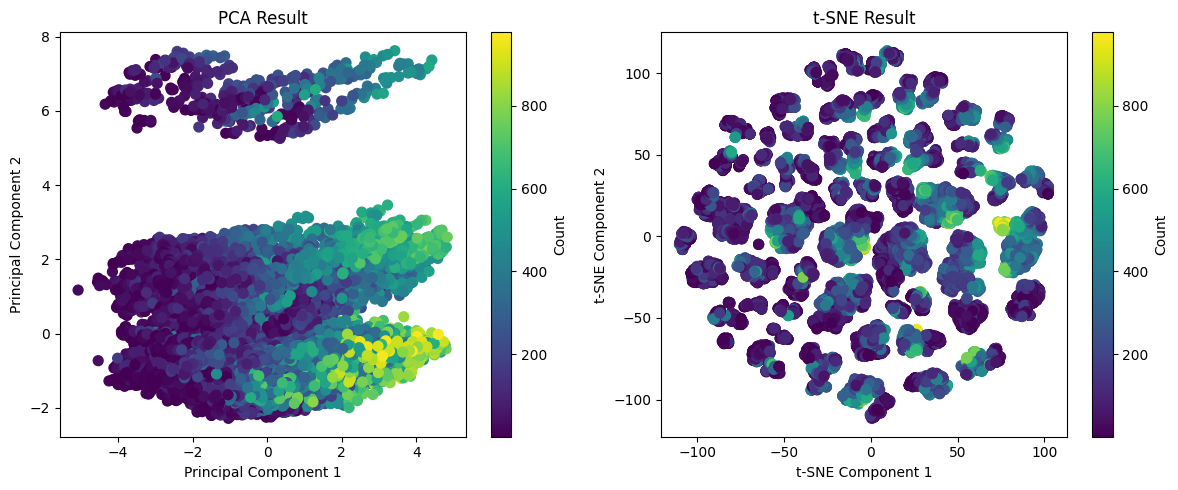

In [30]:
# Plotting PCA results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
plt.title('PCA Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Count')

# Plotting t-SNE results
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', s=50)
plt.title('t-SNE Result')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Count')
plt.tight_layout()
plt.show()

From the plots we can see a clear difference for how DR has been applied. PCA tries to separate the data globally, whereas t-SNE forms local neighbourhoods, smaller clusters of data. Let's compare how different features contribute to the two components extracted.

Next, let's visualize how different features contribute to the components in PCA and t-SNE. For PCA, we can visualize the heatmap for PCA component loading for each feature. For t-SNE, we can instead show the correlations between original features and the t-SNE coordinates.

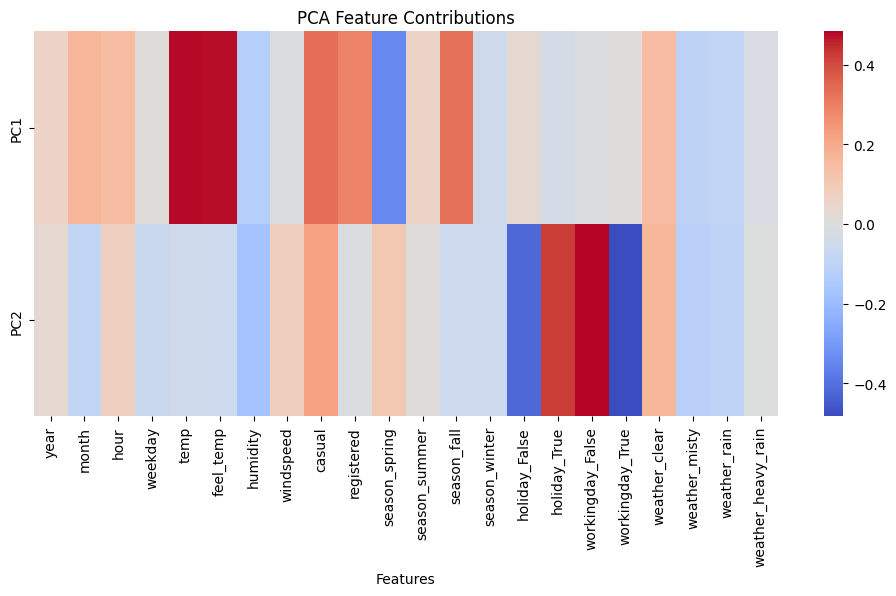

In [31]:
plt.figure(figsize=(12, 5))
components_df = pd.DataFrame(pca.components_, columns=df.drop(columns=['count']).columns, index=['PC1', 'PC2'])
sns.heatmap(components_df, annot=False, cmap='coolwarm')
plt.title('PCA Feature Contributions')
plt.xlabel('Features')
plt.show()

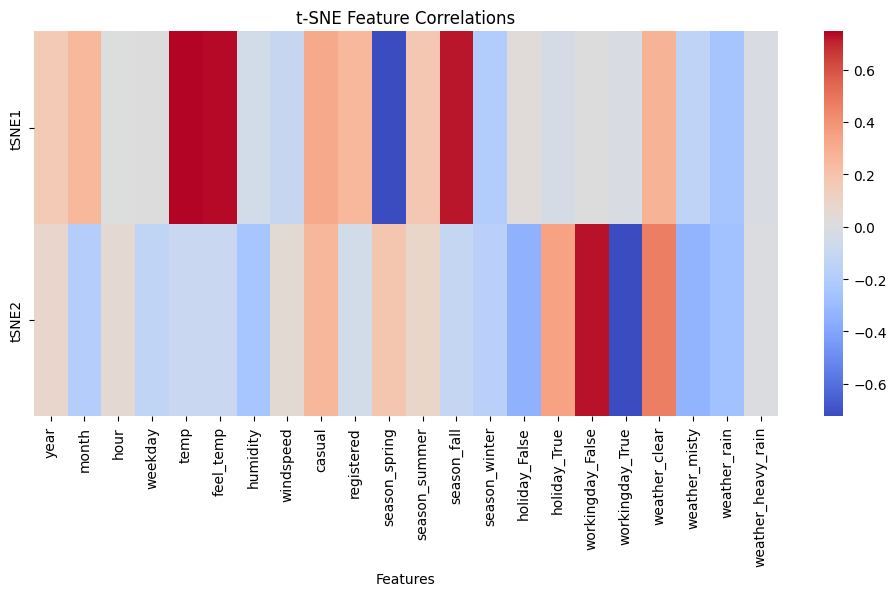

In [32]:
tsne_df = pd.DataFrame(X_tsne, columns=['tSNE1', 'tSNE2'])
original_df = pd.DataFrame(X, columns=df.drop(columns=['count']).columns)
correlation_matrix = original_df.corrwith(tsne_df['tSNE1']).to_frame(name='tSNE1')
correlation_matrix['tSNE2'] = original_df.corrwith(tsne_df['tSNE2'])
plt.figure(figsize=(12, 5))
sns.heatmap(correlation_matrix.T, annot=False, cmap='coolwarm')
plt.title('t-SNE Feature Correlations')
plt.xlabel('Features')
plt.show()


From both heatmaps we can see similarities on feature contributions. Some notable observations:
- Temperature and feeled temperature correlate positively with the bike rental counts -> higher the temperature, the better the rental counts
- Working day correlates strongly with the rental counts -> counts are higher on non-working days, and naturally lower on working days

Let's tune the PCA by selecting the number of components that explain 90% of the total variance.

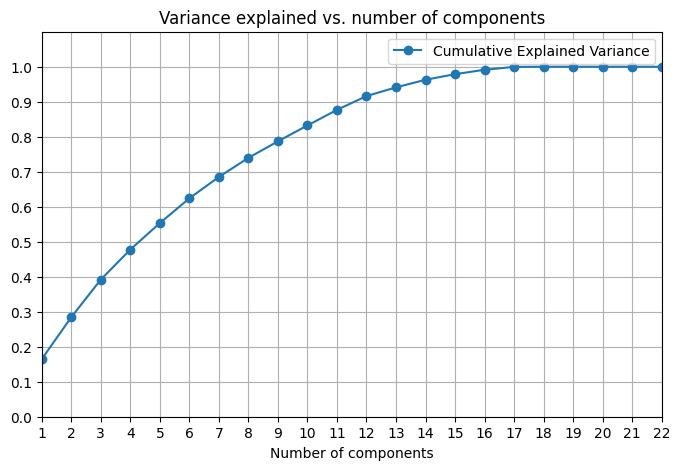

Number of components to explain 90% variance: 12


In [33]:
X_pca_full = PCA().fit_transform(X)
explained_variance = np.cumsum(PCA().fit(X).explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label='Cumulative Explained Variance')
plt.title('Variance explained vs. number of components')
plt.xlabel('Number of components')
plt.legend()
plt.grid()
plt.xticks(range(1, len(explained_variance) + 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axis((1, len(explained_variance), 0, 1.1))
plt.show()

n_components_90 = np.argmax(explained_variance >= 0.9) + 1
print(f"Number of components to explain 90% variance: {n_components_90}")

Let's use 12 components for PCA for the prediction model. For t-SNE, let's use the same number of components.

In [47]:
def mlp_estimator(X_train, X_test, y_train):

    model = MLPRegressor(hidden_layer_sizes=(100,50), max_iter=500, random_state=42)
    model.fit(X_train, y_train)

    return model.predict(X_test)

In [65]:
# Original data, no DR
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X,y, test_size=0.3, random_state=42)
y_pred_original = mlp_estimator(X_train_original, X_test_original, y_train_original)
mse_original = mean_squared_error(y_test_original, y_pred_original)

In [66]:
# PCA 
pca_model = PCA(n_components=n_components_90).fit(X_train_original)
X_train_pca = pca_model.transform(X_train_original)
X_test_pca = pca_model.transform(X_test_original)
y_pred_pca = mlp_estimator(X_train_pca, X_test_pca, y_train_original)
mse_pca = mean_squared_error(y_test_original, y_pred_pca)

In [54]:
# t-SNE (we need to use the entire dataset for fitting t-SNE, then split that again to train and test)
tsne_model = TSNE(n_components=2)
X_tsne = tsne_model.fit_transform(X)
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(X_tsne, y, test_size=0.3, random_state=42)
y_pred_tsne = mlp_estimator(X_train_tsne, X_test_tsne, y_train_tsne)
mse_tsne = mean_squared_error(y_test_tsne, y_pred_tsne)

In [67]:
# MSE comparison
print("MSE, Original data:", mse_original)
print("MSE, PCA:", mse_pca)
print("MSE, t-SNE:", mse_tsne)

MSE, Original data: 0.6880855462398208
MSE, PCA: 44.94218090392683
MSE, t-SNE: 14442.876118956985


Estimation results for t-SNE are really bad, while PCA gives moderate estimation results based on the MSE value. With no DR, the estimation results are very good. Let's visualize still the prediction results to compare the different methods

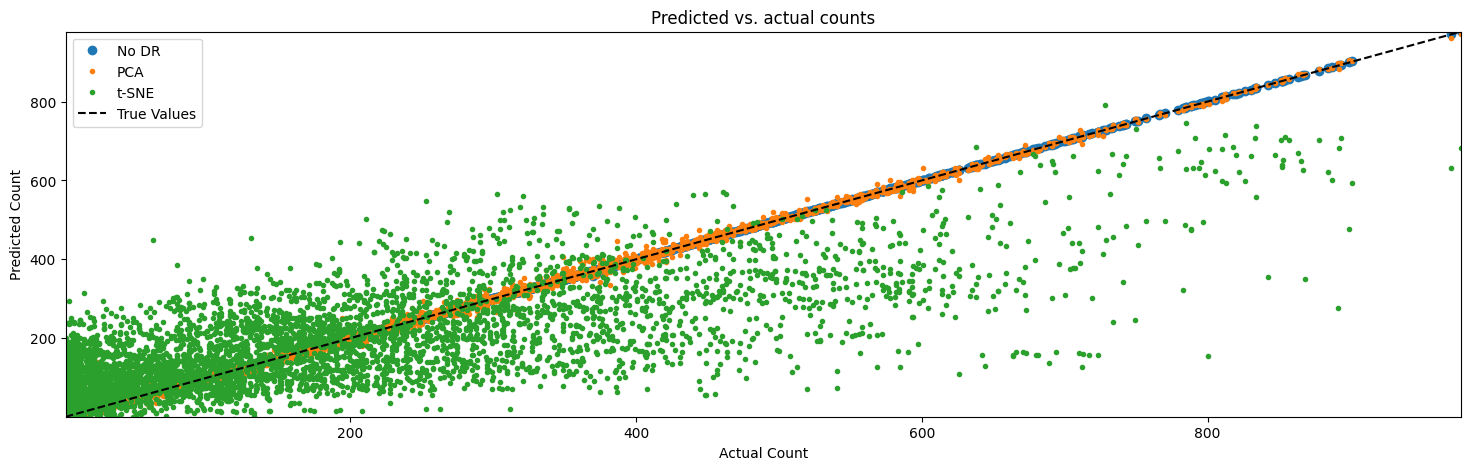

In [68]:
plt.figure(figsize=(18, 5))
plt.plot(y_test_original, y_pred_original, 'o', label='No DR')
plt.plot(y_test_original, y_pred_pca, '.', label='PCA')
plt.plot(y_test_tsne, y_pred_tsne, '.', label='t-SNE')
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', label='True Values')
plt.xlabel('Actual Count')
plt.ylabel('Predicted Count')
plt.title('Predicted vs. actual counts')
plt.legend()
plt.axis((min(y), max(y), min(y), max(y)))
plt.show()


From the plot we can see, that t-SNE performs really badly for the estimation task, having a large margin of error. PCA with 12 components gives rather well estimation results. 

The problematic part with t-SNE and using it with MLP is likely that the extracted information about local features is not really taken into consideration by the model, so a lot of information is lost. Some other methods could make t-SNE even outperform PCA, but for this simple MLP example the difference was significantly in favour of PCA.

### 2. Visualizing with SOM (3 points)

Visualize MNIST-784 handwritten digits dataset with SOM and discuss what you can learn from the visualization.

Importing libraries. For training the SOM, I'm using `MiniSom` library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
from scipy.io import arff
import pandas as pd

Loading the data and training the SOM

In [10]:
data, meta = arff.loadarff('mnist_784.arff')
df = pd.DataFrame(data)

df['class'] = df['class'].astype(int)

# Store data and labels
X = df.drop(columns=['class']).values
y = df['class'].values

# Data normalization
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

som_size = 20 
som = MiniSom(x=som_size, y=som_size, input_len=784, sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_scaled)
som.train_random(X_scaled, num_iteration=10000, verbose=True)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 4.956674260139033


Let's build a matrix for storing the mapping results for each sample

In [11]:
class_map = np.zeros((som_size, som_size, 10))
for i, x in enumerate(X_scaled):
    w = som.winner(x)
    class_map[w[0], w[1], y[i]] += 1

For SOM visualization, let's plot:
- Dominant digit per node (to show if the classes are clustered together)
- Sample distribution (to see if the samples are getting evenly hit in the SOM)
- U-matrix (to see how well the class separation works)

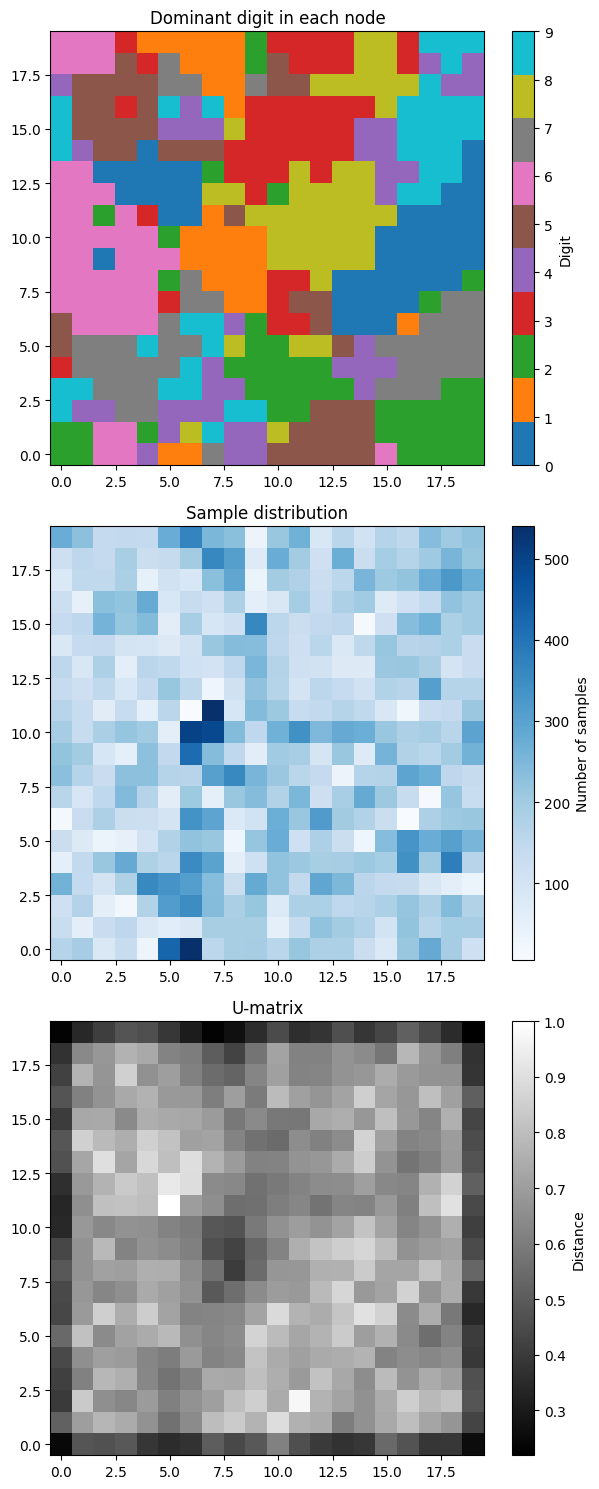

In [18]:
plt.figure(figsize=(6, 15))

# show the dominant class for each node
plt.subplot(3, 1, 1)
winner_class = np.argmax(class_map, axis=2)
plt.imshow(winner_class.T, cmap='tab10', origin='lower')
plt.colorbar(label='Digit', ticks=range(10))
plt.title('Dominant digit in each node')

# sample distribution
plt.subplot(3, 1, 2)
hit_frequency = np.sum(class_map, axis=2)
plt.imshow(hit_frequency.T, cmap='Blues', origin='lower')
plt.colorbar(label='Number of samples')
plt.title('Sample distribution')

# u-matrix
plt.subplot(3, 1, 3)
u_matrix = som.distance_map()
plt.imshow(u_matrix.T, cmap='gray', origin='lower')
plt.colorbar(label='Distance')
plt.title('U-matrix')

plt.tight_layout()
plt.show()

From the plots we can learn the following:
1. Based on the dominant digits plot, we can see that the classes are well clustered together, which can be seen as large areas of only one digit being dominant. The clustering is not perfect since there are some individual nodes with completely different digit being dominant than all the neighbour nodes, but overall the mapping seems to work well.
2. From the sample distribution we can see that there are couple of nodes with significantly more hits than others. Other than these couple of nodes, the distribution is somewhat even between the nodes
3. The U-matrix displays how different the feature vectors are between the neighbour nodes (calculating vector distances). Dark area means that the features are very similar, so we are in the middle of the cluster. Light areas display areas with big differences, meaning a border of different clusters. The dark/light areas are not too strong in the U-matrix, so the data is not that well clustered. One significant dark spot can be seen in the center (around node 8,8) where is a cluster of digit 1. Some really light nodes can also be seen, so a border between two clusters is strong in these areas